<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [32]:
import glob
import pickle

In [3]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
train_data = pd.read_csv("../data/train.csv")
# Binning the numeric variable to different categories
target_std=train_data['target'].std()
max_target=train_data['target'].max()+1
min_target=train_data['target'].min()-1
bins=[min_target,-3*target_std,-2*target_std,-1*target_std,target_std*1,target_std*2,target_std*3,max_target]
labels=[-4,-3,-2,0,2,3,4]
train_data['target_bin']=pd.cut(train_data['target'],bins=bins,labels=labels).astype(int)
train_data['target_bin']=train_data['target_bin'].abs()
train_data.groupby(['target_bin']).size()

target_bin
0    191093
2      8200
3       363
4      2261
dtype: int64

In [47]:
def run_lgb(train_X, train_y, val_X, val_y):
    param = {'num_leaves': 300,
             'min_data_in_leaf': 100,
             'objective': 'regression',
             'max_depth': 15,
             'learning_rate': 0.01,
             "boosting": "gbdt",
             "feature_fraction": 0.9,
             "bagging_freq": 1,
             "bagging_fraction": 0.8,
             "bagging_seed": 11,
             "metric": 'rmse',
             # "lambda_l1": 0.2634,
             "random_state": 133,
             "verbosity": -1}

    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(param, lgtrain, 2000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100,
                      evals_result=evals_result)
    return model, evals_result


In [53]:
def model_run(filepath,train_data1):
    for file in filepath:
        data_features = pd.read_csv(file)
        train_data1=pd.merge(train_data1,data_features,how='left',on='card_id')
    output_feature=['target']
    input_features=[x for x in train_data1.columns if x not in ['first_active_month', 'card_id','target','target_bin']]
    train_X = train_data1[input_features]
    train_y = train_data1[output_feature]
    X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_data1['target_bin'], test_size=0.2, random_state=42)
    # random state:42
    # random state: 100
    # random state: 892
    y_train1=train_y.loc[y_train.index,:]
    y_valid1=train_y.loc[y_valid.index,:]
    model, evals_result = run_lgb(X_train,y_train1, X_valid, y_valid1)
    return(model, evals_result)

## card level features

### card_summary_history

In [19]:
model, evals_result=model_run(["../Fresh/card_summary_history.csv"])

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.8001
[200]	valid_0's rmse: 3.7839
[300]	valid_0's rmse: 3.78004
Did not meet early stopping. Best iteration is:
[288]	valid_0's rmse: 3.77986


### card_summary_future

In [6]:
model, evals_result=model_run(["../Fresh/card_summary_future.csv"],train_data)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.81166
[200]	valid_0's rmse: 3.7986
[300]	valid_0's rmse: 3.79585
Did not meet early stopping. Best iteration is:
[297]	valid_0's rmse: 3.79584


### Combined

In [8]:
model, evals_result=model_run(["../Fresh/card_summary_future.csv","../Fresh/card_summary_history.csv"],train_data)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.75522
[200]	valid_0's rmse: 3.72703
[300]	valid_0's rmse: 3.71822
Did not meet early stopping. Best iteration is:
[300]	valid_0's rmse: 3.71822


### diff hist feature and dates

### Trail1

In [13]:
filelist=glob.glob("../Fresh/*.csv")

In [15]:
filelist

['../Fresh\\active_first_diff.csv',
 '../Fresh\\card_summary_future.csv',
 '../Fresh\\card_summary_history.csv',
 '../Fresh\\diffhistfuture.csv',
 '../Fresh\\future_length.csv',
 '../Fresh\\hist_length.csv',
 '../Fresh\\ref_first_future.csv',
 '../Fresh\\ref_last_hist.csv']

In [14]:
model, evals_result=model_run(filelist,train_data)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.74958
[200]	valid_0's rmse: 3.71907
[300]	valid_0's rmse: 3.70869
Did not meet early stopping. Best iteration is:
[298]	valid_0's rmse: 3.70865


### Trail2

In [16]:
filelist=glob.glob("../Fresh/*.csv")
filelist

['../Fresh\\active_first_diff.csv',
 '../Fresh\\card_summary_future.csv',
 '../Fresh\\card_summary_history.csv',
 '../Fresh\\diffhistfuture.csv',
 '../Fresh\\future_length.csv',
 '../Fresh\\hist_length.csv',
 '../Fresh\\ref_first_future.csv',
 '../Fresh\\ref_last_hist.csv',
 '../Fresh\\trans_amount_monthly.csv']

In [17]:
model, evals_result=model_run(filelist,train_data)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.74899
[200]	valid_0's rmse: 3.7193
[300]	valid_0's rmse: 3.7096
Did not meet early stopping. Best iteration is:
[300]	valid_0's rmse: 3.7096


### Trail3

In [9]:
model, evals_result=model_run(["../Fresh/card_summary_future.csv","../Fresh/card_summary_history.csv","../Fresh/diffhistfuture.csv"],train_data)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.75202
[200]	valid_0's rmse: 3.72465
[300]	valid_0's rmse: 3.71662
Did not meet early stopping. Best iteration is:
[300]	valid_0's rmse: 3.71662


### Trail4

In [27]:
filelist=glob.glob("../Fresh/*.csv")
filelist

['../Fresh\\active_first_diff.csv',
 '../Fresh\\card_new_mercid.csv',
 '../Fresh\\card_summary_future.csv',
 '../Fresh\\card_summary_history.csv',
 '../Fresh\\diffhistfuture.csv',
 '../Fresh\\future_length.csv',
 '../Fresh\\hist_length.csv',
 '../Fresh\\ref_first_future.csv',
 '../Fresh\\ref_last_hist.csv',
 '../Fresh\\trend.csv']

In [28]:
model, evals_result=model_run(filelist,train_data)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.74131
[200]	valid_0's rmse: 3.71229
[300]	valid_0's rmse: 3.70306
Did not meet early stopping. Best iteration is:
[300]	valid_0's rmse: 3.70306


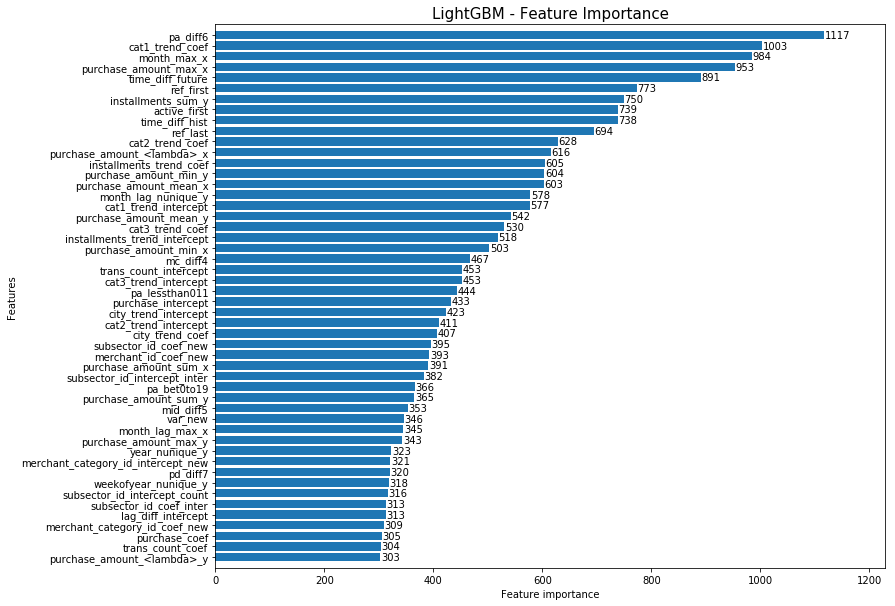

In [29]:
%matplotlib inline 
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

### Trail5

In [20]:
filelist=glob.glob("../Fresh/*.csv")
filelist

['../Fresh\\active_first_diff.csv',
 '../Fresh\\card_new_mercid.csv',
 '../Fresh\\card_summary_future.csv',
 '../Fresh\\card_summary_history.csv',
 '../Fresh\\diffhistfuture.csv',
 '../Fresh\\future_length.csv',
 '../Fresh\\hist_length.csv',
 '../Fresh\\ref_first_future.csv',
 '../Fresh\\ref_last_hist.csv',
 '../Fresh\\trend.csv']

In [22]:
model, evals_result=model_run(filelist,train_data)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.74131
[200]	valid_0's rmse: 3.71229
[300]	valid_0's rmse: 3.70306
Did not meet early stopping. Best iteration is:
[300]	valid_0's rmse: 3.70306


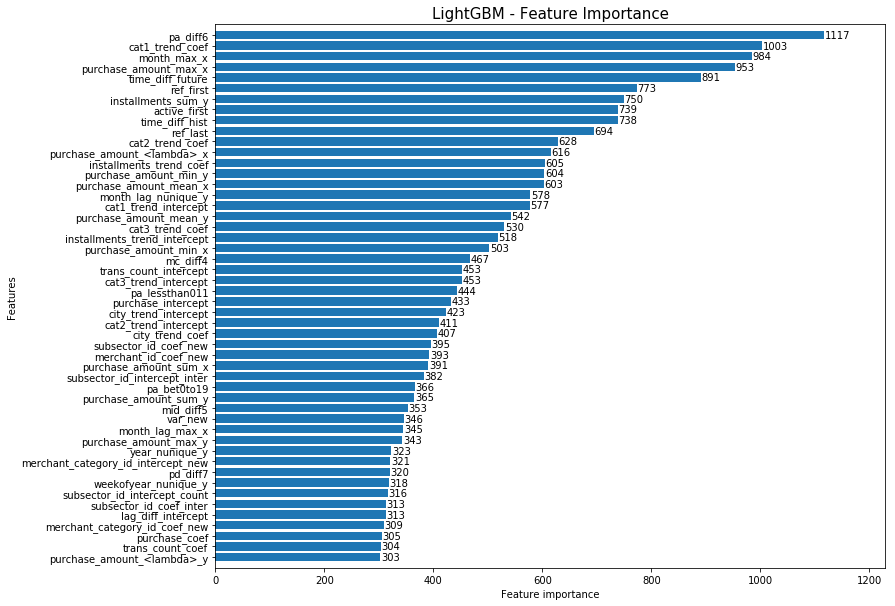

In [24]:
%matplotlib inline 
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

### Trail6

In [31]:
filelist=glob.glob("../Fresh/*.csv")
print(filelist)
model, evals_result=model_run(filelist,train_data)
%matplotlib inline 
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

['../Fresh\\active_first_diff.csv', '../Fresh\\card_new_mercid.csv', '../Fresh\\card_summary_future.csv', '../Fresh\\card_summary_history.csv', '../Fresh\\category1N.csv', '../Fresh\\category1Y.csv', '../Fresh\\category21.0.csv', '../Fresh\\category22.0.csv', '../Fresh\\category23.0.csv', '../Fresh\\category24.0.csv', '../Fresh\\category25.0.csv', '../Fresh\\category3A.csv', '../Fresh\\category3B.csv', '../Fresh\\category3C.csv', '../Fresh\\diffhistfuture.csv', '../Fresh\\future_length.csv', '../Fresh\\hist_length.csv', '../Fresh\\ref_first_future.csv', '../Fresh\\ref_last_hist.csv', '../Fresh\\trend.csv']


ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in fields category_1N, category_1Y, category_3A, category_3B, category_3C

#### Trail7

['../Fresh\\active_first_diff.csv', '../Fresh\\card_new_mercid.csv', '../Fresh\\card_summary_future.csv', '../Fresh\\card_summary_history.csv', '../Fresh\\category1N.csv', '../Fresh\\category1Y.csv', '../Fresh\\category21.0.csv', '../Fresh\\category22.0.csv', '../Fresh\\category23.0.csv', '../Fresh\\category24.0.csv', '../Fresh\\category25.0.csv', '../Fresh\\category3A.csv', '../Fresh\\category3B.csv', '../Fresh\\category3C.csv', '../Fresh\\diffhistfuture.csv', '../Fresh\\future_length.csv', '../Fresh\\hist_length.csv', '../Fresh\\ref_first_future.csv', '../Fresh\\ref_last_hist.csv', '../Fresh\\trend.csv']
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.7361
[200]	valid_0's rmse: 3.70726
[300]	valid_0's rmse: 3.69923
Did not meet early stopping. Best iteration is:
[300]	valid_0's rmse: 3.69923


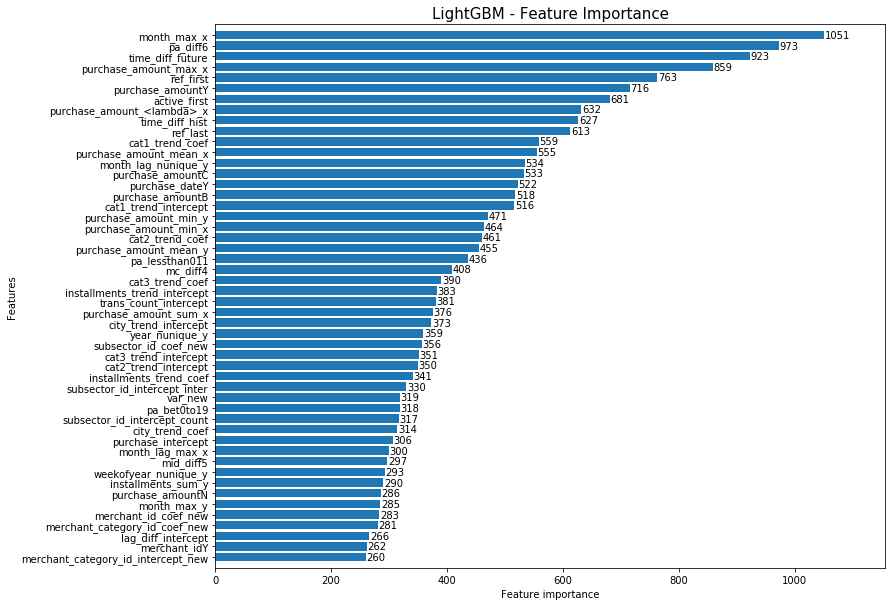

In [33]:
filelist7=glob.glob("../Fresh/*.csv")
pickle.dump( filelist7, open( "filelist7.p", "wb" ) )
print(filelist)
model, evals_result=model_run(filelist7,train_data)
%matplotlib inline 
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

### Trail8

['../Fresh\\active_first_diff.csv', '../Fresh\\card_new_mercid.csv', '../Fresh\\card_summary_future.csv', '../Fresh\\card_summary_history.csv', '../Fresh\\category1N.csv', '../Fresh\\category1Y.csv', '../Fresh\\category21.0.csv', '../Fresh\\category22.0.csv', '../Fresh\\category23.0.csv', '../Fresh\\category24.0.csv', '../Fresh\\category25.0.csv', '../Fresh\\category3A.csv', '../Fresh\\category3B.csv', '../Fresh\\category3C.csv', '../Fresh\\diffhistfuture.csv', '../Fresh\\future_length.csv', '../Fresh\\hist_length.csv', '../Fresh\\ref_first_future.csv', '../Fresh\\ref_last_hist.csv', '../Fresh\\trend.csv']
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.73595
[200]	valid_0's rmse: 3.70726
[300]	valid_0's rmse: 3.69806
Did not meet early stopping. Best iteration is:
[300]	valid_0's rmse: 3.69806


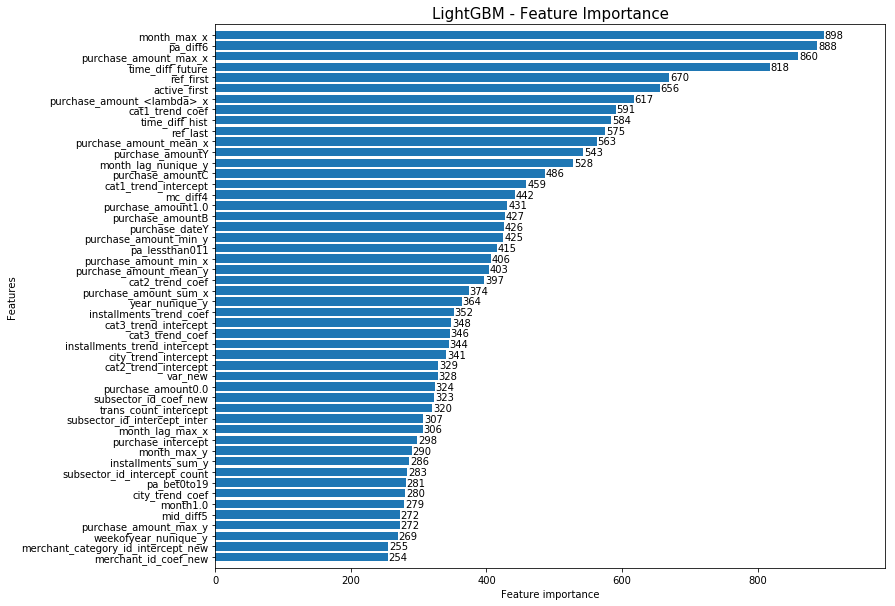

In [35]:
filelist8=glob.glob("../Fresh/*.csv")
pickle.dump( filelist8, open( "filelist8.p", "wb" ) )
print(filelist8)
model, evals_result=model_run(filelist8,train_data)
%matplotlib inline 
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

#### Attempt9

['../Fresh\\active_first_diff.csv', '../Fresh\\card_new_mercid.csv', '../Fresh\\card_summary_future.csv', '../Fresh\\card_summary_history.csv', '../Fresh\\card_summary_month_history.csv', '../Fresh\\category1_allN.csv', '../Fresh\\category1_allY.csv', '../Fresh\\category2_all0.0.csv', '../Fresh\\category2_all1.0.csv', '../Fresh\\category2_all2.0.csv', '../Fresh\\category2_all3.0.csv', '../Fresh\\category2_all4.0.csv', '../Fresh\\category2_all5.0.csv', '../Fresh\\category3_allA.csv', '../Fresh\\category3_allB.csv', '../Fresh\\category3_allC.csv', '../Fresh\\diffhistfuture.csv', '../Fresh\\future_length.csv', '../Fresh\\hist_length.csv', '../Fresh\\ref_first_future.csv', '../Fresh\\ref_last_hist.csv', '../Fresh\\trend.csv']
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.74041
[200]	valid_0's rmse: 3.70991
[300]	valid_0's rmse: 3.70142
Did not meet early stopping. Best iteration is:
[299]	valid_0's rmse: 3.70142


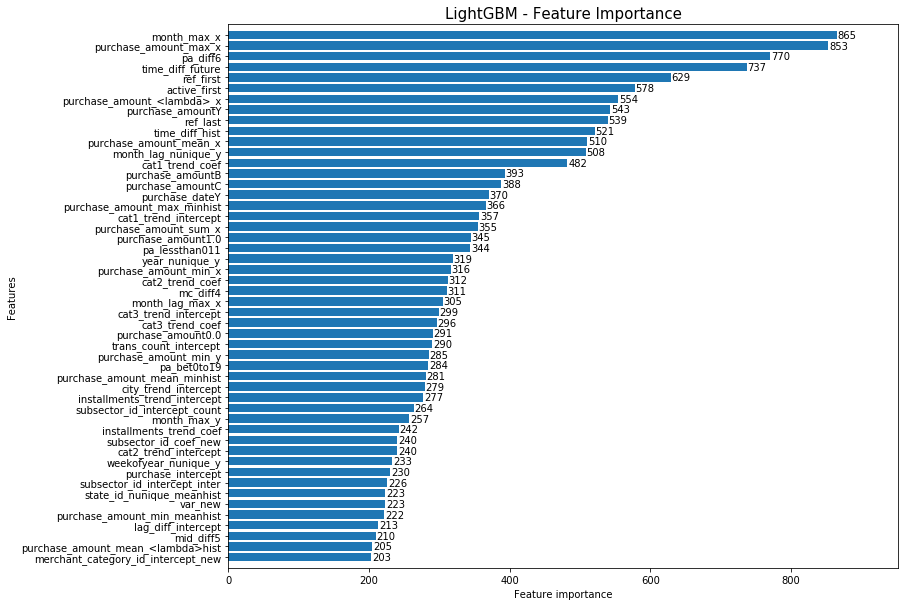

In [38]:
filelist9=glob.glob("../Fresh/*.csv")
pickle.dump( filelist8, open( "filelist9.p", "wb" ) )
print(filelist9)
model, evals_result=model_run(filelist9,train_data)
%matplotlib inline 
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

#### Attempt10

['../Fresh/card_summary_month_history.csv']
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.86838
[200]	valid_0's rmse: 3.86675
[300]	valid_0's rmse: 3.86699
Did not meet early stopping. Best iteration is:
[243]	valid_0's rmse: 3.86664


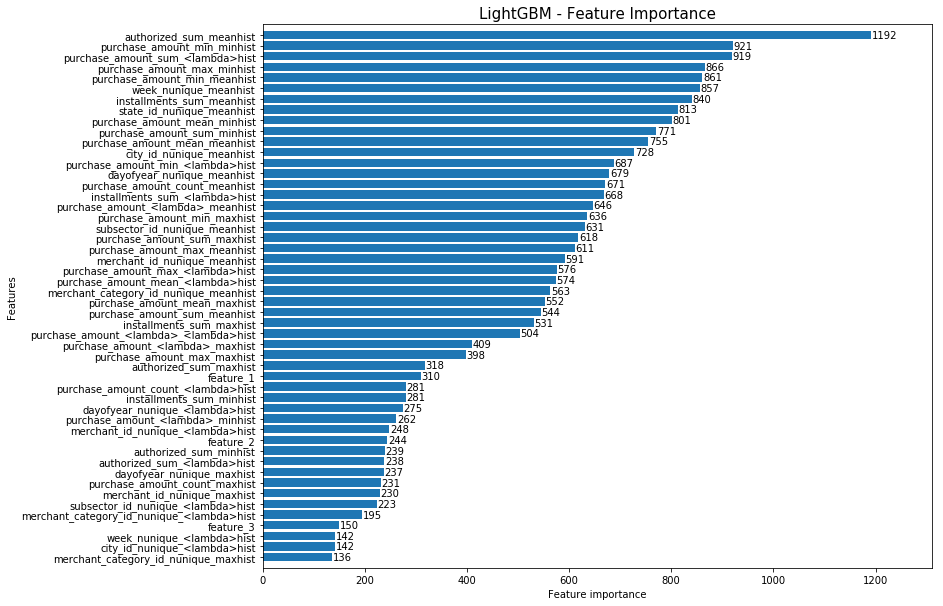

In [41]:
filelist10=['../Fresh/card_summary_month_history.csv']
# pickle.dump( filelist8, open( "filelist9.p", "wb" ) )
print(filelist10)
model, evals_result=model_run(filelist10,train_data)
%matplotlib inline 
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

#### Trail 10

['../Fresh\\active_first_diff.csv', '../Fresh\\card_new_mercid.csv', '../Fresh\\card_summary_future.csv', '../Fresh\\card_summary_history.csv', '../Fresh\\category1_allN.csv', '../Fresh\\category1_allY.csv', '../Fresh\\category2_all0.0.csv', '../Fresh\\category2_all1.0.csv', '../Fresh\\category2_all2.0.csv', '../Fresh\\category2_all3.0.csv', '../Fresh\\category2_all4.0.csv', '../Fresh\\category2_all5.0.csv', '../Fresh\\category3_allA.csv', '../Fresh\\category3_allB.csv', '../Fresh\\category3_allC.csv', '../Fresh\\diffhistfuture.csv', '../Fresh\\future_length.csv', '../Fresh\\hist_length.csv', '../Fresh\\quarter_purchase_count.csv', '../Fresh\\quarter_purchase_sum.csv', '../Fresh\\ref_first_future.csv', '../Fresh\\ref_last_hist.csv', '../Fresh\\trend.csv']
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.73625
[200]	valid_0's rmse: 3.70835
[300]	valid_0's rmse: 3.69999
Did not meet early stopping. Best iteration is:
[298]	valid_0's rmse: 3.69997


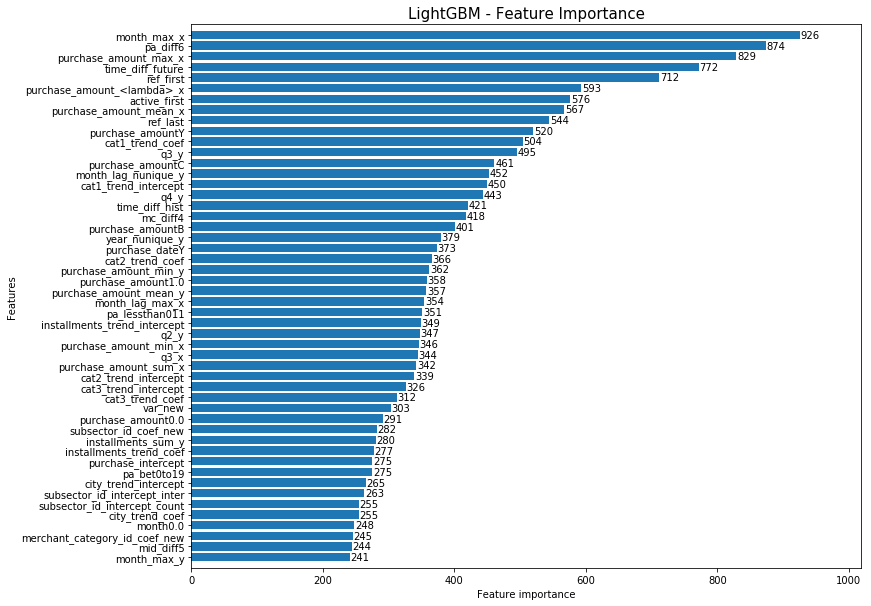

In [42]:
filelist10=glob.glob("../Fresh/*.csv")
pickle.dump( filelist8, open( "filelist10.p", "wb" ) )
print(filelist10)
model, evals_result=model_run(filelist10,train_data)
%matplotlib inline 
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

#### Attempt11

['../Fresh\\active_first_diff.csv', '../Fresh\\card_new_mercid.csv', '../Fresh\\card_summary_future.csv', '../Fresh\\card_summary_history.csv', '../Fresh\\category1_allN.csv', '../Fresh\\category1_allY.csv', '../Fresh\\category2_all0.0.csv', '../Fresh\\category2_all1.0.csv', '../Fresh\\category2_all2.0.csv', '../Fresh\\category2_all3.0.csv', '../Fresh\\category2_all4.0.csv', '../Fresh\\category2_all5.0.csv', '../Fresh\\category3_allA.csv', '../Fresh\\category3_allB.csv', '../Fresh\\category3_allC.csv', '../Fresh\\diffhistfuture.csv', '../Fresh\\future_length.csv', '../Fresh\\hist_length.csv', '../Fresh\\quarter_purchase_count.csv', '../Fresh\\quarter_purchase_sum.csv', '../Fresh\\ref_first_future.csv', '../Fresh\\ref_last_hist.csv', '../Fresh\\trend.csv']
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.73498
[200]	valid_0's rmse: 3.70586
[300]	valid_0's rmse: 3.69657
Did not meet early stopping. Best iteration is:
[300]	valid_0's rmse: 3.69657


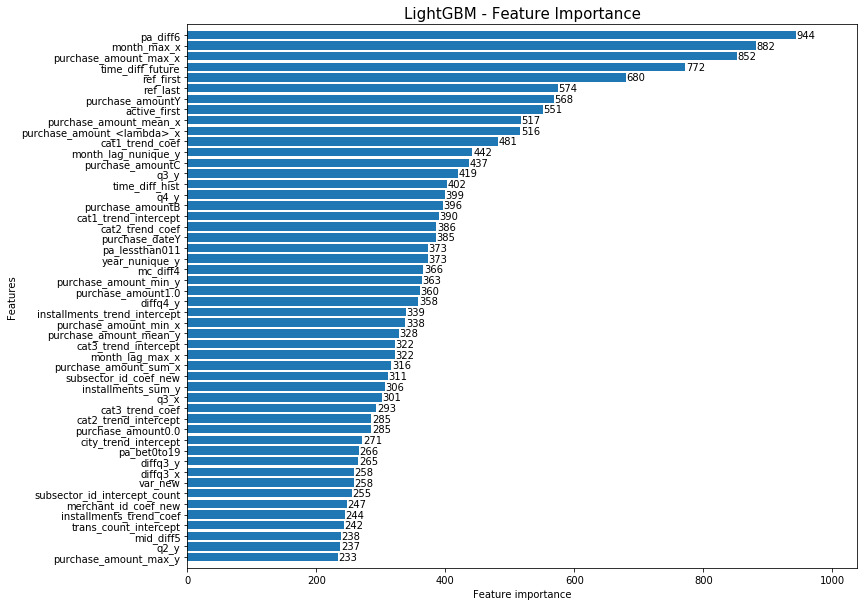

In [43]:
filelist11=glob.glob("../Fresh/*.csv")
pickle.dump( filelist11, open( "filelist11.p", "wb" ) )
print(filelist11)
model, evals_result=model_run(filelist11,train_data)
%matplotlib inline 
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

#### Attempt12

['../Fresh\\active_first_diff.csv', '../Fresh\\card_new_mercid.csv', '../Fresh\\card_summary_future.csv', '../Fresh\\card_summary_history.csv', '../Fresh\\category1_allN.csv', '../Fresh\\category1_allY.csv', '../Fresh\\category2_all0.0.csv', '../Fresh\\category2_all1.0.csv', '../Fresh\\category2_all2.0.csv', '../Fresh\\category2_all3.0.csv', '../Fresh\\category2_all4.0.csv', '../Fresh\\category2_all5.0.csv', '../Fresh\\category3_allA.csv', '../Fresh\\category3_allB.csv', '../Fresh\\category3_allC.csv', '../Fresh\\diffhistfuture.csv', '../Fresh\\future_length.csv', '../Fresh\\hist_length.csv', '../Fresh\\quarter_purchase_count.csv', '../Fresh\\quarter_purchase_sum.csv', '../Fresh\\ref_first_future.csv', '../Fresh\\ref_last_hist.csv', '../Fresh\\trend.csv']
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.54523
[200]	valid_0's rmse: 3.52621
[300]	valid_0's rmse: 3.5245
Early stopping, best iteration is:
[269]	valid_0's rmse: 3.52419


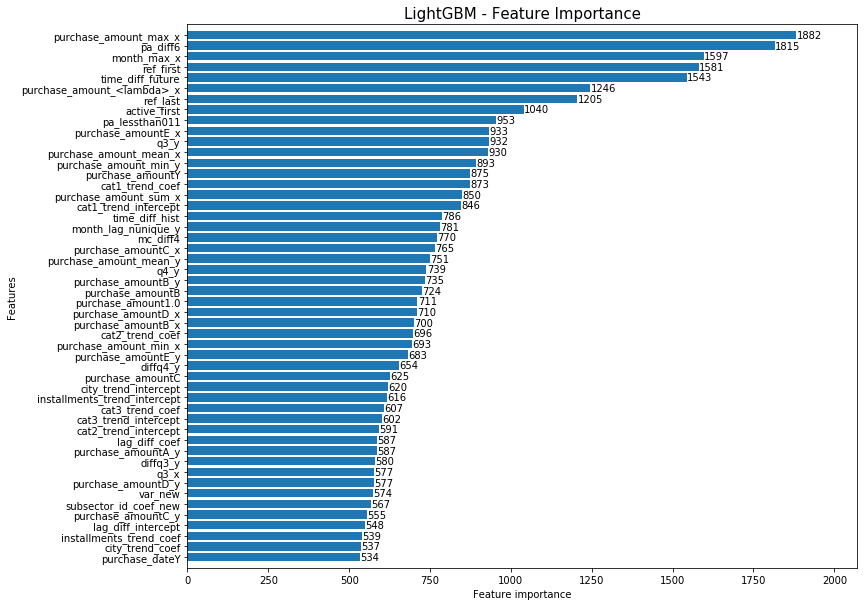

In [50]:
filelist12=glob.glob("../Fresh/*.csv")
pickle.dump( filelist12, open( "filelist12.p", "wb" ) )
print(filelist11)
model, evals_result=model_run(filelist12,train_data)
%matplotlib inline 
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

['../Fresh\\active_first_diff.csv', '../Fresh\\card_new_mercid.csv', '../Fresh\\card_summary_future.csv', '../Fresh\\card_summary_history.csv', '../Fresh\\category1_allN.csv', '../Fresh\\category1_allY.csv', '../Fresh\\category2_all0.0.csv', '../Fresh\\category2_all1.0.csv', '../Fresh\\category2_all2.0.csv', '../Fresh\\category2_all3.0.csv', '../Fresh\\category2_all4.0.csv', '../Fresh\\category2_all5.0.csv', '../Fresh\\category3_allA.csv', '../Fresh\\category3_allB.csv', '../Fresh\\category3_allC.csv', '../Fresh\\diffhistfuture.csv', '../Fresh\\future_length.csv', '../Fresh\\hist_length.csv', '../Fresh\\quarter_purchase_count.csv', '../Fresh\\quarter_purchase_sum.csv', '../Fresh\\ref_first_future.csv', '../Fresh\\ref_last_hist.csv', '../Fresh\\trend.csv']
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.66283
[200]	valid_0's rmse: 3.63919
[300]	valid_0's rmse: 3.63281
[400]	valid_0's rmse: 3.63067
[500]	valid_0's rmse: 3.63094
Early stopping, best 

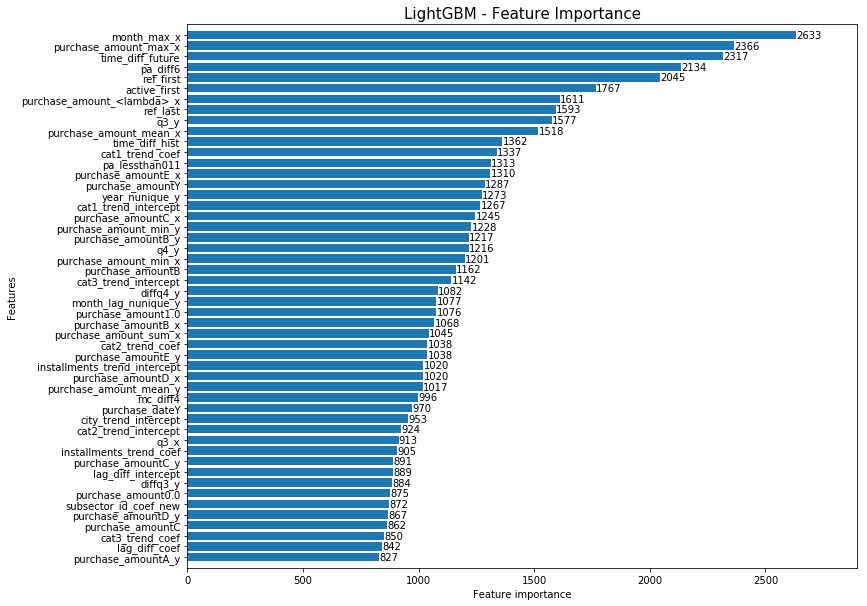

In [52]:
filelist12=glob.glob("../Fresh/*.csv")
pickle.dump( filelist12, open( "filelist12.p", "wb" ) )
print(filelist11)
model, evals_result=model_run(filelist12,train_data)
%matplotlib inline 
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

['../Fresh\\active_first_diff.csv', '../Fresh\\card_new_mercid.csv', '../Fresh\\card_summary_future.csv', '../Fresh\\card_summary_history.csv', '../Fresh\\category1_allN.csv', '../Fresh\\category1_allY.csv', '../Fresh\\category2_all0.0.csv', '../Fresh\\category2_all1.0.csv', '../Fresh\\category2_all2.0.csv', '../Fresh\\category2_all3.0.csv', '../Fresh\\category2_all4.0.csv', '../Fresh\\category2_all5.0.csv', '../Fresh\\category3_allA.csv', '../Fresh\\category3_allB.csv', '../Fresh\\category3_allC.csv', '../Fresh\\diffhistfuture.csv', '../Fresh\\future_length.csv', '../Fresh\\hist_length.csv', '../Fresh\\quarter_purchase_count.csv', '../Fresh\\quarter_purchase_sum.csv', '../Fresh\\ref_first_future.csv', '../Fresh\\ref_last_hist.csv', '../Fresh\\trend.csv']
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.72766
[200]	valid_0's rmse: 3.70113
[300]	valid_0's rmse: 3.69495
[400]	valid_0's rmse: 3.69302
[500]	valid_0's rmse: 3.69282
Early stopping, best 

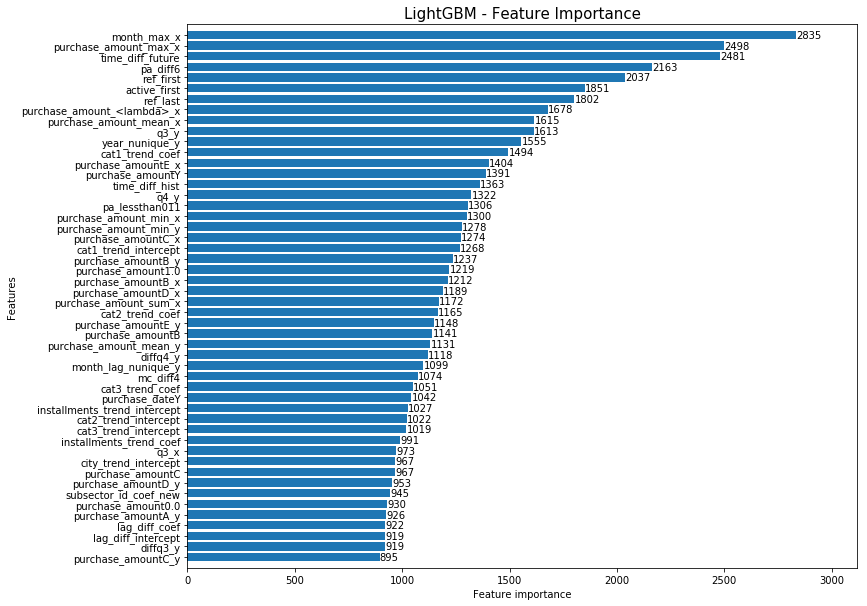

In [54]:
filelist12=glob.glob("../Fresh/*.csv")
pickle.dump( filelist12, open( "filelist12.p", "wb" ) )
print(filelist11)
model, evals_result=model_run(filelist12,train_data)
%matplotlib inline 
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()